In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
class RandomForestRegressor:
    """
    Random Forest Regressor.

    Attributes:
        n_estimators (int): The number of trees in the forest.
        max_depth (int): The maximum depth of the trees.
        min_samples_split (int): The minimum number of samples required to split an internal node.
        min_samples_leaf (int): The minimum number of samples required to be at a leaf node.
        random_state (int):  Controls the randomness of the bootstrapping and feature selection.
    """
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=None):
        """
        Initializes the RandomForestRegressor.

        Args:
            n_estimators (int, optional): The number of trees in the forest. Defaults to 100.
            max_depth (int, optional): The maximum depth of the trees. Defaults to None (unlimited depth).
            min_samples_split (int, optional): The minimum number of samples required to split an internal node. Defaults to 2.
            min_samples_leaf (int, optional): The minimum number of samples required to be at a leaf node. Defaults to 1.
            random_state (int, optional): Controls the randomness. Defaults to None.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []  # List to store the individual decision trees
        self.feature_indices = [] # List to store the indices of the features used for each tree

    def fit(self, X, y):
        """
        Builds the random forest from the training data.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The target values, shape (n_samples,).
        """
        n_samples, n_features = X.shape
        if self.random_state:
            np.random.seed(self.random_state)

        # Build each tree
        for _ in range(self.n_estimators):
            # 1. Bootstrap the data
            bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrapped = X[bootstrap_indices]
            y_bootstrapped = y[bootstrap_indices]

            # 2. Select a random subset of features
            n_features_subset = int(np.sqrt(n_features))  # Typically sqrt(n_features) for regression
            feature_indices = np.random.choice(n_features, n_features_subset, replace=False)
            self.feature_indices.append(feature_indices) #store

            X_bootstrapped_subset = X_bootstrapped[:, feature_indices]

            # 3. Build a decision tree
            tree = DecisionTreeRegressor(max_depth=self.max_depth,
                                         )  # Pass other hyperparameters as needed
            tree.fit(X_bootstrapped_subset, y_bootstrapped)
            self.trees.append(tree)

    def predict(self, X):
        """
        Predicts the output for the given data by averaging the predictions of all trees.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).

        Returns:
            ndarray: The predicted values, shape (n_samples,).
        """
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)
        
        for i, tree in enumerate(self.trees):
            # Get the features that this tree used
            feature_indices = self.feature_indices[i]
            # Select only those features from the input
            X_subset = X[:, feature_indices]
            tree_predictions = tree.predict(X_subset) # Make prediction
            predictions += tree_predictions # Accumulate predictions

        return predictions / self.n_estimators  # Average the predictions

    def score(self, X, y):
        """
        Calculates the coefficient of determination (R^2) of the prediction.

        Args:
            X (ndarray): Input features, shape (n_samples, n_features).
            y (ndarray): True target values, shape (n_samples,).

        Returns:
            float: R^2 score.
        """
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

In [5]:
class DecisionTreeRegressor:
    """
    Decision Tree Regressor.

    Attributes:
        max_depth (int): The maximum depth of the tree.
    """
    def __init__(self, max_depth=None):
        """
        Initializes the DecisionTreeRegressor.

        Args:
            max_depth (int, optional): The maximum depth of the tree. Defaults to None (unlimited depth).
        """
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        """
        Builds the decision tree from the training data.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The target values, shape (n_samples,).
        """
        self.tree = self._build_tree(X, y, depth=0)

    def predict(self, X):
        """
        Predicts the output for the given data.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).

        Returns:
            ndarray: The predicted values, shape (n_samples,).
        """
        predictions = [self._predict_one(x, self.tree) for x in X]
        return np.array(predictions)

    def _build_tree(self, X, y, depth):
        """
        Recursively builds the decision tree.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The target values, shape (n_samples,).
            depth (int): The current depth of the tree.

        Returns:
            dict: A dictionary representing the decision tree node.
        """
        n_samples, n_features = X.shape

        # Base cases:
        # 1. If there are no more samples, return the mean of the target values.
        if n_samples == 0:
            return {'value': np.mean(y)}
        # 2. If all target values are the same, return that value.
        if np.all(y == y[0]):
            return {'value': y[0]}
        # 3. If the maximum depth is reached, return the mean of the target values.
        if self.max_depth is not None and depth >= self.max_depth:
            return {'value': np.mean(y)}
        # 4. If there are no more features to split on
        if n_features == 0:
            return {'value': np.mean(y)}

        # Try to find the best possible feature and threshold to split on
        best_split = self._get_best_split(X, y)

        # If no good split is found, return the mean of the target values
        if best_split['feature_index'] is None:
            return {'value': np.mean(y)}

        # Split data and recursively build left and right subtrees
        left_X, left_y = best_split['left_X'], best_split['left_y']
        right_X, right_y = best_split['right_X'], best_split['right_y']

        left_child = self._build_tree(left_X, left_y, depth + 1)
        right_child = self._build_tree(right_X, right_y, depth + 1)

        # Return the node
        return {
            'feature_index': best_split['feature_index'],
            'threshold': best_split['threshold'],
            'left_child': left_child,
            'right_child': right_child,
        }

    def _get_best_split(self, X, y):
        """
        Finds the best split for the data based on the variance reduction.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The target values, shape (n_samples,).

        Returns:
            dict: A dictionary containing the best split information.
                {'feature_index': int, 'threshold': float, 'left_X': ndarray, 'left_y': ndarray,
                 'right_X': ndarray, 'right_y': ndarray}
        """
        n_samples, n_features = X.shape
        if n_features == 0:
            return {}

        # Calculate the initial variance
        initial_variance = np.var(y)
        best_variance_reduction = 0
        best_split = {}

        for feature_index in range(n_features):
            # Get the unique values of the feature
            feature_values = np.unique(X[:, feature_index])
            #consider all values as thresholds
            for threshold in feature_values:
                # Split the data based on the threshold
                left_mask = X[:, feature_index] <= threshold
                right_mask = X[:, feature_index] > threshold
                left_X, left_y = X[left_mask], y[left_mask]
                right_X, right_y = X[right_mask], y[right_mask]

                # Calculate the variance reduction
                if len(left_y) > 0 and len(right_y) > 0:
                    left_variance = np.var(left_y)
                    right_variance = np.var(right_y)
                    variance_reduction = initial_variance - (len(left_y) / n_samples) * left_variance - (
                        len(right_y) / n_samples
                    ) * right_variance

                    # Update the best split if it's better than the current best
                    if variance_reduction > best_variance_reduction:
                        best_variance_reduction = variance_reduction
                        best_split = {
                            'feature_index': feature_index,
                            'threshold': threshold,
                            'left_X': left_X,
                            'left_y': left_y,
                            'right_X': right_X,
                            'right_y': right_y,
                        }

        return best_split

    def _predict_one(self, x, node):
        """
        Predicts the output for a single data point using the decision tree.

        Args:
            x (ndarray): A single data point with shape (n_features,).
            node (dict): A dictionary representing a decision tree node.

        Returns:
            float: The predicted value.
        """
        # If the node is a leaf node, return the value
        if 'value' in node:
            return node['value']

        # Otherwise, go to the left or right child based on the feature value
        if x[node['feature_index']] <= node['threshold']:
            return self._predict_one(x, node['left_child'])
        else:
            return self._predict_one(x, node['right_child'])
        
    def score(self, X, y):
        """
        Calculates the coefficient of determination (R^2) of the prediction.

        Args:
            X (ndarray): Input features, shape (n_samples, n_features).
            y (ndarray): True target values, shape (n_samples,).

        Returns:
            float: R^2 score.
        """
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

In [7]:
# Load dataset
df = pd.read_csv("cleaned_mlb_2022_full.csv")

# Select features and target
features = ['Barrel%', 'EV', 'LA', 'BB%', 'K%', 'Contact%', 'Swing%', 'O-Swing%']
target = 'WAR'

X = df[features].values
y = df[target].values

# Normalize features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

In [9]:
# Train custom random forest
rf = RandomForestRegressor(n_estimators=25, max_depth=4, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")


RMSE: 2.02
MAE: 1.70
R² Score: -0.13


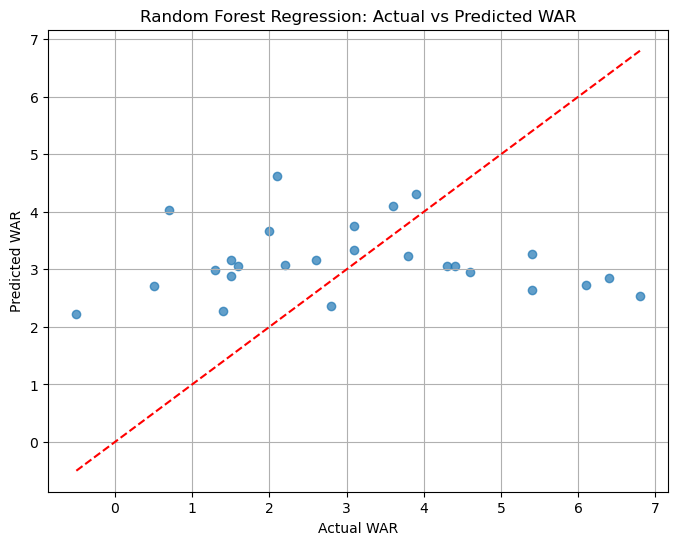

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual WAR")
plt.ylabel("Predicted WAR")
plt.title("Random Forest Regression: Actual vs Predicted WAR")
plt.grid(True)
plt.show()

In the first scatter plot, we compare actual vs. predicted WAR. While we still see underfitting — with predictions clustering around a narrow range (roughly 2.5 to 3.5 WAR) — the predictions are more centered and less erratic than the Decision Tree’s output. There is a subtle improvement in how well the predictions track the diagonal reference line.

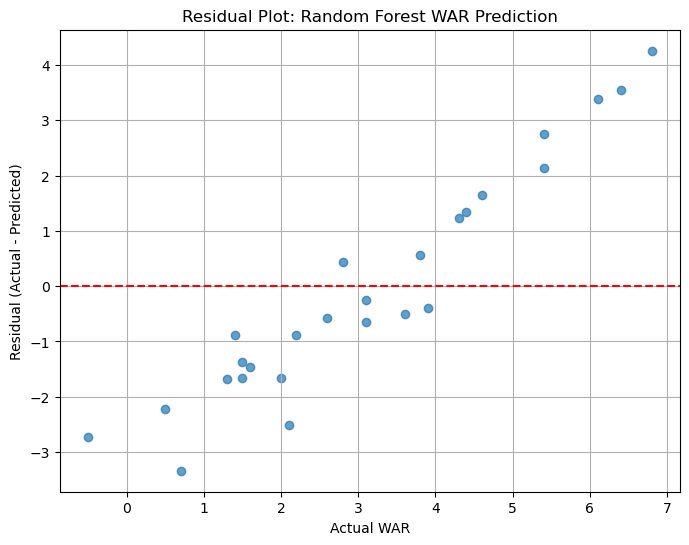

In [13]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual WAR")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot: Random Forest WAR Prediction")
plt.grid(True)
plt.show()


The residual plot highlights the model’s systematic error. Many predictions still underestimate true WAR for higher-performing players. However, the residual spread is tighter compared to the single tree model, indicating more stability. There is a clearer funnel shape that suggests prediction variance increases with WAR — a common challenge when few training points exist at the high end.

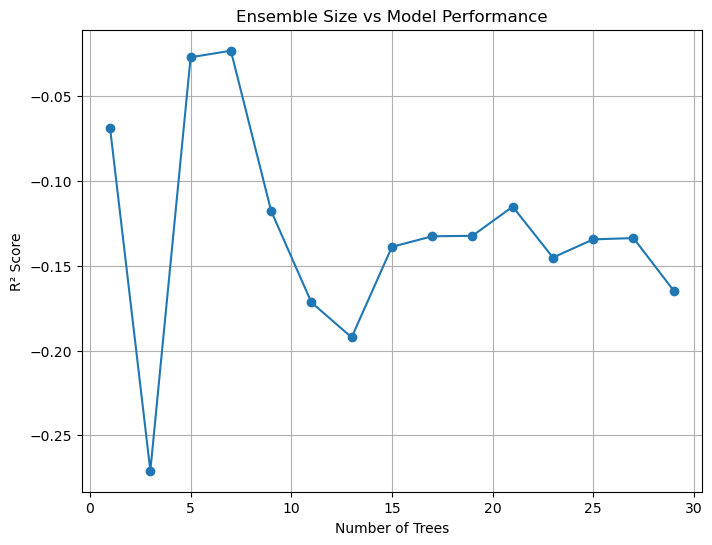

In [15]:
tree_counts = list(range(1, 31, 2))
r2_scores = []

for n in tree_counts:
    model = RandomForestRegressor(n_estimators=n, max_depth=4, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2_scores.append(r2_score(y_test, preds))

plt.figure(figsize=(8, 6))
plt.plot(tree_counts, r2_scores, marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("R² Score")
plt.title("Ensemble Size vs Model Performance")
plt.grid(True)
plt.show()


The final graph shows how model performance varies with the number of trees. Interestingly, the model briefly improves around 5–7 trees before plateauing or even slightly declining. This suggests we may not benefit much from increasing tree count beyond a small ensemble in this particular dataset — likely due to its size and feature limits. It also underscores that blindly scaling up model complexity does not always lead to better performance.

Our Random Forest model, trained with 25 estimators and a max depth of 4, offered modest improvements over the Decision Tree. While the R² score remained negative at -0.13 (compared to -0.56), both RMSE and MAE improved slightly to 2.02 and 1.70 respectively. These metrics suggest that although the model still underperforms a basic mean predictor, it is better at reducing large errors and stabilizing predictions. The actual vs. predicted WAR plot shows the same tendency as the Decision Tree to compress predictions around a narrow range, though with slightly better alignment along the ideal diagonal. The residual plot shows reduced variance and a more coherent structure, with most residuals clustering within a tighter band, although the model still systematically underpredicts higher-WAR players. Notably, the ensemble size vs. performance plot reveals that adding more trees yields diminishing returns—performance peaks around 5 to 7 trees and stabilizes or declines thereafter, hinting that the dataset’s size and feature richness may be limiting the Random Forest’s potential. Overall, while ensemble learning helps smooth predictions and reduce overfitting compared to a single tree, the marginal gains suggest that either the model’s capacity or the dataset’s structure is capping performance. This points to the value of considering more expressive models, such as boosting or neural networks, or enriching the feature space to better capture variation in WAR.